### Configurações de ambiente

In [1]:
# === Standard Library ===
import json
import os
import re
import string
import copy
import random

# === Third-party Libraries ===

# Data handling
import nltk
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# Visualization
from great_tables import GT, md, html
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import plotly

# Plotly high-resolution export settings
plotly.io.renderers.default = "png"

# Set default font to Helvetica Neue in Plotly
plotly.io.templates["custom"] = plotly.io.templates["plotly_white"]
plotly.io.templates["custom"].layout.font.family = "Helvetica Neue"
plotly.io.templates.default = "custom"

# Matplotlib high-resolution settings
plt.rcParams["figure.dpi"] = 300
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["font.family"] = "Helvetica Neue"

# Machine Learning & Deep Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
)

# Optimization
# import optuna

# External integrations
import kagglehub

# === Project-specific Imports ===
from neural_networks.lstm import LSTMClassifier
from neural_networks.rnn import RNNClassifier

/Users/vkz/mini-projeto-2/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [2]:
SEED = 7777777
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.backends.mps.is_available():
    torch.mps.manual_seed(SEED)

try:
    torch.use_deterministic_algorithms(True)
except RuntimeError as e:
    print("⚠️  MPS op without deterministic implementation encountered:", e)

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

In [3]:
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# Warning: MPS backend is not yet fully supported in PyTorch, and some operations may not be deterministic.
# For reproducibility, it's recommended to use CPU.
device = "cpu"
device

'cpu'

In [4]:
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("stopwords")
nltk.download("omw-1.4")

[nltk_data] Downloading package punkt to /Users/vkz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/vkz/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/vkz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/vkz/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [5]:
nltk.data.path.append("/Users/vkz/nltk_data")

In [6]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

In [7]:
path = kagglehub.dataset_download("charunisa/chatgpt-sentiment-analysis")
df = pd.read_csv(os.path.join(path, "file.csv"))
df = df.drop(columns=["Unnamed: 0"])
label_map = {"bad": 0, "neutral": 1, "good": 2}
df["labels"] = df["labels"].map(label_map)
df

,tweets,labels
0,ChatGPT: Optimizing Language Models for Dialog...,1
1,"Try talking with ChatGPT, our new AI system wh...",2
2,ChatGPT: Optimizing Language Models for Dialog...,1
3,"THRILLED to share that ChatGPT, our new model ...",2
4,"As of 2 minutes ago, @OpenAI released their ne...",0
...,...,...
219289,Other Software Projects Are Now Trying to Repl...,0
219290,I asked #ChatGPT to write a #NYE Joke for SEOs...,2
219291,chatgpt is being disassembled until it can onl...,0
219292,2023 predictions by #chatGPT. Nothing really s...,0


## Tratamento de dados

Balanceando as classes do dataset

In [8]:
bad_df = df[df["labels"] == 0]
neutral_df = df[df["labels"] == 1]
good_df = df[df["labels"] == 2]

min_count = min(len(bad_df), len(neutral_df), len(good_df))

bad_bal = resample(bad_df, n_samples=min_count, random_state=SEED)
neutral_bal = resample(neutral_df, n_samples=min_count, random_state=SEED)
good_bal = resample(good_df, n_samples=min_count, random_state=SEED)

df_balanced = (
    pd.concat([bad_bal, neutral_bal, good_bal])
    .sample(frac=1, random_state=SEED)
    .reset_index(drop=True)
)

df = df_balanced.copy()
print(df["labels"].value_counts())

labels
0    55487
2    55487
1    55487
Name: count, dtype: int64


Removendo elementos da internet

In [9]:
def strip_text(text: str) -> str:
    text = text.replace("\\n", " ").replace("\n", " ")  # remove newlines
    text = text.lower()
    text = re.sub(r"http\S+", "", text)  # remove URLs
    text = re.sub(r"@\w+", "", text)  # remove mentions
    text = re.sub(r"#\w+", "", text)  # remove hashtags
    text = re.sub(r"[^\w\s]", "", text)  # remove punctuation
    text = re.sub(r"\s+", " ", text).strip()  # normalize whitespace
    return text

In [10]:
df["stripped_tweets"] = df["tweets"].apply(strip_text)
df

,tweets,labels,stripped_tweets
0,😭 not chatgpt conspiracies https://t.co/hZegVn...,0,not chatgpt conspiracies
1,"It's officially ""CHEAT GPT""\n#ChatGPT",0,its officially cheat gpt
2,"In the past few weeks, there have been repeate...",2,in the past few weeks there have been repeated...
3,ChatGPT: Can Artificial Intelligence really re...,1,chatgpt can artificial intelligence really rep...
4,I've seen people saying that machine-learning ...,1,ive seen people saying that machinelearning mo...
...,...,...,...
166456,Getting a seed phrase out of ChatGPT is like p...,1,getting a seed phrase out of chatgpt is like p...
166457,#ChatGPT Wrote This Article About Large Langua...,0,wrote this article about large language models
166458,I gave ChatGPT to one of my young boys for uni...,2,i gave chatgpt to one of my young boys for uni...
166459,I asked ChatGPT for 5 simple design gifts.\n\n...,0,i asked chatgpt for 5 simple design gifts here...


Aplicando lemmatização

In [11]:
tokenizer = TreebankWordTokenizer()


def normalize_text(text: str) -> str:
    words = tokenizer.tokenize(text)
    cleaned = [
        lemmatizer.lemmatize(w)
        for w in words
        if w.lower() not in stop_words and w not in string.punctuation
    ]
    return " ".join(cleaned)

In [12]:
df["normalized_tweets"] = df["stripped_tweets"].apply(normalize_text)
df

,tweets,labels,stripped_tweets,normalized_tweets
0,😭 not chatgpt conspiracies https://t.co/hZegVn...,0,not chatgpt conspiracies,chatgpt conspiracy
1,"It's officially ""CHEAT GPT""\n#ChatGPT",0,its officially cheat gpt,officially cheat gpt
2,"In the past few weeks, there have been repeate...",2,in the past few weeks there have been repeated...,past week repeated report test chatbot chatgpt...
3,ChatGPT: Can Artificial Intelligence really re...,1,chatgpt can artificial intelligence really rep...,chatgpt artificial intelligence really replace...
4,I've seen people saying that machine-learning ...,1,ive seen people saying that machinelearning mo...,ive seen people saying machinelearning model l...
...,...,...,...,...
166456,Getting a seed phrase out of ChatGPT is like p...,1,getting a seed phrase out of chatgpt is like p...,getting seed phrase chatgpt like pulling teeth
166457,#ChatGPT Wrote This Article About Large Langua...,0,wrote this article about large language models,wrote article large language model
166458,I gave ChatGPT to one of my young boys for uni...,2,i gave chatgpt to one of my young boys for uni...,gave chatgpt one young boy uni he enjoying
166459,I asked ChatGPT for 5 simple design gifts.\n\n...,0,i asked chatgpt for 5 simple design gifts here...,asked chatgpt 5 simple design gift here suggested


Construindo vocabulário

In [13]:
from collections import Counter


def build_vocab(texts, min_freq=2):
    counter = Counter()
    for tweet in texts:
        counter.update(tweet.split())
    vocab = {"<pad>": 0, "<unk>": 1}
    for word, freq in counter.items():
        if freq >= min_freq:
            vocab[word] = len(vocab)
    return vocab


vocab = build_vocab(df["normalized_tweets"])
vocab_size = len(vocab)

with open("nlp/vocab.json", "w") as f:
    json.dump(vocab, f)

In [14]:
def tweet_to_indices(tweet, vocab):
    return [vocab.get(word, vocab["<unk>"]) for word in tweet.split()]


df["indexed_tweets"] = df["normalized_tweets"].apply(
    lambda x: tweet_to_indices(x, vocab)
)

In [15]:
class TweetDataset(Dataset):
    def __init__(self, texts, labels):
        self.sequences = [torch.tensor(seq, dtype=torch.long) for seq in texts]
        self.labels = torch.tensor(labels.values, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]


def collate_fn(batch):
    sequences, labels = zip(*batch)
    padded = pad_sequence(sequences, batch_first=True, padding_value=vocab["<pad>"])
    return padded, torch.tensor(labels)

In [16]:
train_df, test_df = train_test_split(
    df,
    test_size=0.3,
    stratify=df_balanced["labels"],
    random_state=SEED,
)

train_df, holdout_df = train_test_split(
    train_df,
    test_size=0.1,
    stratify=train_df["labels"],
    random_state=SEED,
)

print(f"Train size: {len(train_df)}")
print(f"Test size: {len(test_df)}")
print(f"Holdout size: {len(holdout_df)}")

print("\nTrain distribution:\n", train_df["labels"].value_counts())
print("\nTest distribution:\n", test_df["labels"].value_counts())
print("\nHoldout distribution:\n", holdout_df["labels"].value_counts())

Train size: 104869
Test size: 49939
Holdout size: 11653

Train distribution:
 labels
0    34957
1    34956
2    34956
Name: count, dtype: int64

Test distribution:
 labels
1    16647
0    16646
2    16646
Name: count, dtype: int64

Holdout distribution:
 labels
2    3885
0    3884
1    3884
Name: count, dtype: int64


In [17]:
train_df

,tweets,labels,stripped_tweets,normalized_tweets,indexed_tweets
130646,Caught Chatgpt red handed.. asked what day is ...,0,caught chatgpt red handed asked what day is to...,caught chatgpt red handed asked day today toda...,"[4503, 2, 1379, 12235, 58, 505, 699, 699, 5365..."
85474,This 🧵 of 🧵 s shows that the most interesting ...,1,this of s shows that the most interesting thin...,show interesting thing chatgpt isnt people com...,"[1213, 57, 77, 2, 618, 35, 337, 143]"
128364,"""It is difficult to predict the future of any ...",2,it is difficult to predict the future of any p...,difficult predict future particular mathematic...,"[3543, 257, 260, 1123, 4631, 356, 3995, 4531, ..."
9554,"Tell me about your dreams, #ChatGPT! https://t...",1,tell me about your dreams,tell dream,"[113, 1322]"
165810,ChatGPT will make it easier for me to learn mo...,1,chatgpt will make it easier for me to learn mo...,chatgpt make easier learn level knowledge,"[2, 183, 980, 739, 275, 1122]"
...,...,...,...,...,...
49355,I taught @OpenAI ChatGPT to run my Thesis proj...,1,i taught chatgpt to run my thesis project hopp...,taught chatgpt run thesis project hopper distr...,"[3185, 2, 281, 6881, 884, 20441, 4847, 5661, 2..."
105369,ChatGpt is 🔥🔥🔥\n\n#ChatGPT #digitalEntrepreneu...,0,chatgpt is,chatgpt,[2]
148818,Google Is Working Behind the Scenes to Protect...,1,google is working behind the scenes to protect...,google working behind scene protect search cha...,"[25, 528, 1656, 944, 3052, 404, 2]"
34123,Exclusive: ChatGPT owner OpenAI projects $1 bi...,1,exclusive chatgpt owner openai projects 1 bill...,exclusive chatgpt owner openai project 1 billi...,"[1333, 2, 3243, 338, 884, 508, 532, 3462, 2679]"


Criando camadas de embedding e abstrações para passar os dados para as redes neurais

In [18]:
train_dataset = TweetDataset(train_df["indexed_tweets"], train_df["labels"])
test_dataset = TweetDataset(test_df["indexed_tweets"], test_df["labels"])
train_loader = DataLoader(
    train_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn
)
test_loader = DataLoader(
    test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn
)

In [19]:
embedding_dim = 100  # TODO: tunar

embedding_layer = torch.nn.Embedding(
    num_embeddings=vocab_size, embedding_dim=embedding_dim, padding_idx=vocab["<pad>"]
)

In [20]:
GRAPHS_PATH = os.path.join(os.getcwd(), "graphs")

In [21]:
def save_classification_report(all_labels, all_preds, filename):
    report = classification_report(
        all_labels,
        all_preds,
        target_names=["Bad", "Neutral", "Good"],
        digits=4,
        output_dict=True,
    )
    df_report = pd.DataFrame(report).T

    columns_order = ["precision", "recall", "f1-score", "support"]
    df_report = df_report[columns_order]
    df_report = df_report.reset_index().rename(columns={"index": "Class"})

    GT(df_report).tab_header(title="Classification Report").tab_stub(
        rowname_col="Class"
    ).fmt_number(decimals=2).save(os.path.join(GRAPHS_PATH, filename))

## Modelagem com RNN e LSTM

In [22]:
def train_model(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch.long())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

In [23]:
def evaluate_model(model, val_loader, device):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            preds = outputs.argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)
    return correct / total

## Treinando os modelos

In [24]:
# Model-specific config
model_params = {
    "vocab_size": len(vocab),
    "embedding_dim": 100,
    "hidden_dim": 128,
    "output_dim": 3,
    "padding_idx": vocab["<pad>"],
}

# Training-specific config
train_config = {"epochs": 10, "lr": 1e-3, "save_dir": "models"}
os.makedirs(train_config["save_dir"], exist_ok=True)


def train_and_save_best(model_class, model_name, **kwargs):
    print(f"🧠 Training {model_name}...")
    model = model_class(**model_params, **kwargs).to(device)

    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=train_config["lr"])

    best_acc, best_model_state = 0.0, None
    train_accuracies, test_accuracies = [], []

    for epoch in range(train_config["epochs"]):
        loss = train_model(model, train_loader, optimizer, criterion, device)
        train_acc = evaluate_model(model, train_loader, device)
        test_acc = evaluate_model(model, test_loader, device)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        if test_acc > best_acc:
            best_acc = test_acc
            best_model_state = copy.deepcopy(model.state_dict())

        print(
            f"Epoch {epoch+1:2d}: Loss = {loss:.4f}, Train Acc = {train_acc:.4f}, Test Acc = {test_acc:.4f}"
        )

    # Save best model
    name = model_name.lower().replace(" ", "_")
    path = os.path.join(train_config["save_dir"], f"best_{name}.pt")

    net_config = {**model_params, **kwargs}

    torch.save(
        {
            "state_dict": best_model_state,
            "config": net_config,
            "metrics": {"best_acc": best_acc},
            "vocab_path": "nlp/vocab.json",
        },
        path,
    )

    print(f"✅ Saved {model_name} with Accuracy = {best_acc:.4f} → {path}")

    # Reload best model
    model.load_state_dict(best_model_state)

    # Get predictions and labels from test set
    all_preds, all_labels, all_probs = [], [], []
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Metrics
    report_dict = classification_report(all_labels, all_preds, output_dict=True)
    cm = confusion_matrix(all_labels, all_preds)

    return {
        "model": model,
        "model_path": path,
        "train_accuracies": train_accuracies,
        "test_accuracies": test_accuracies,
        "confusion_matrix": cm,
        "classification_report": report_dict,
        "preds": all_preds,
        "labels": all_labels,
        "probs": all_probs,
    }

In [25]:
rnn_results = train_and_save_best(RNNClassifier, "RNN")

🧠 Training RNN...
Epoch  1: Loss = 1.1008, Train Acc = 0.3654, Test Acc = 0.3614
Epoch  2: Loss = 1.0979, Train Acc = 0.3428, Test Acc = 0.3412
Epoch  3: Loss = 1.0932, Train Acc = 0.3451, Test Acc = 0.3441
Epoch  4: Loss = 1.0434, Train Acc = 0.4309, Test Acc = 0.4222
Epoch  5: Loss = 0.9298, Train Acc = 0.6544, Test Acc = 0.6297
Epoch  6: Loss = 0.6912, Train Acc = 0.7680, Test Acc = 0.7310
Epoch  7: Loss = 0.5808, Train Acc = 0.8209, Test Acc = 0.7775
Epoch  8: Loss = 0.5750, Train Acc = 0.8287, Test Acc = 0.7879
Epoch  9: Loss = 0.4732, Train Acc = 0.8557, Test Acc = 0.8070
Epoch 10: Loss = 0.6746, Train Acc = 0.6152, Test Acc = 0.5917
✅ Saved RNN with Accuracy = 0.8070 → models/best_rnn.pt


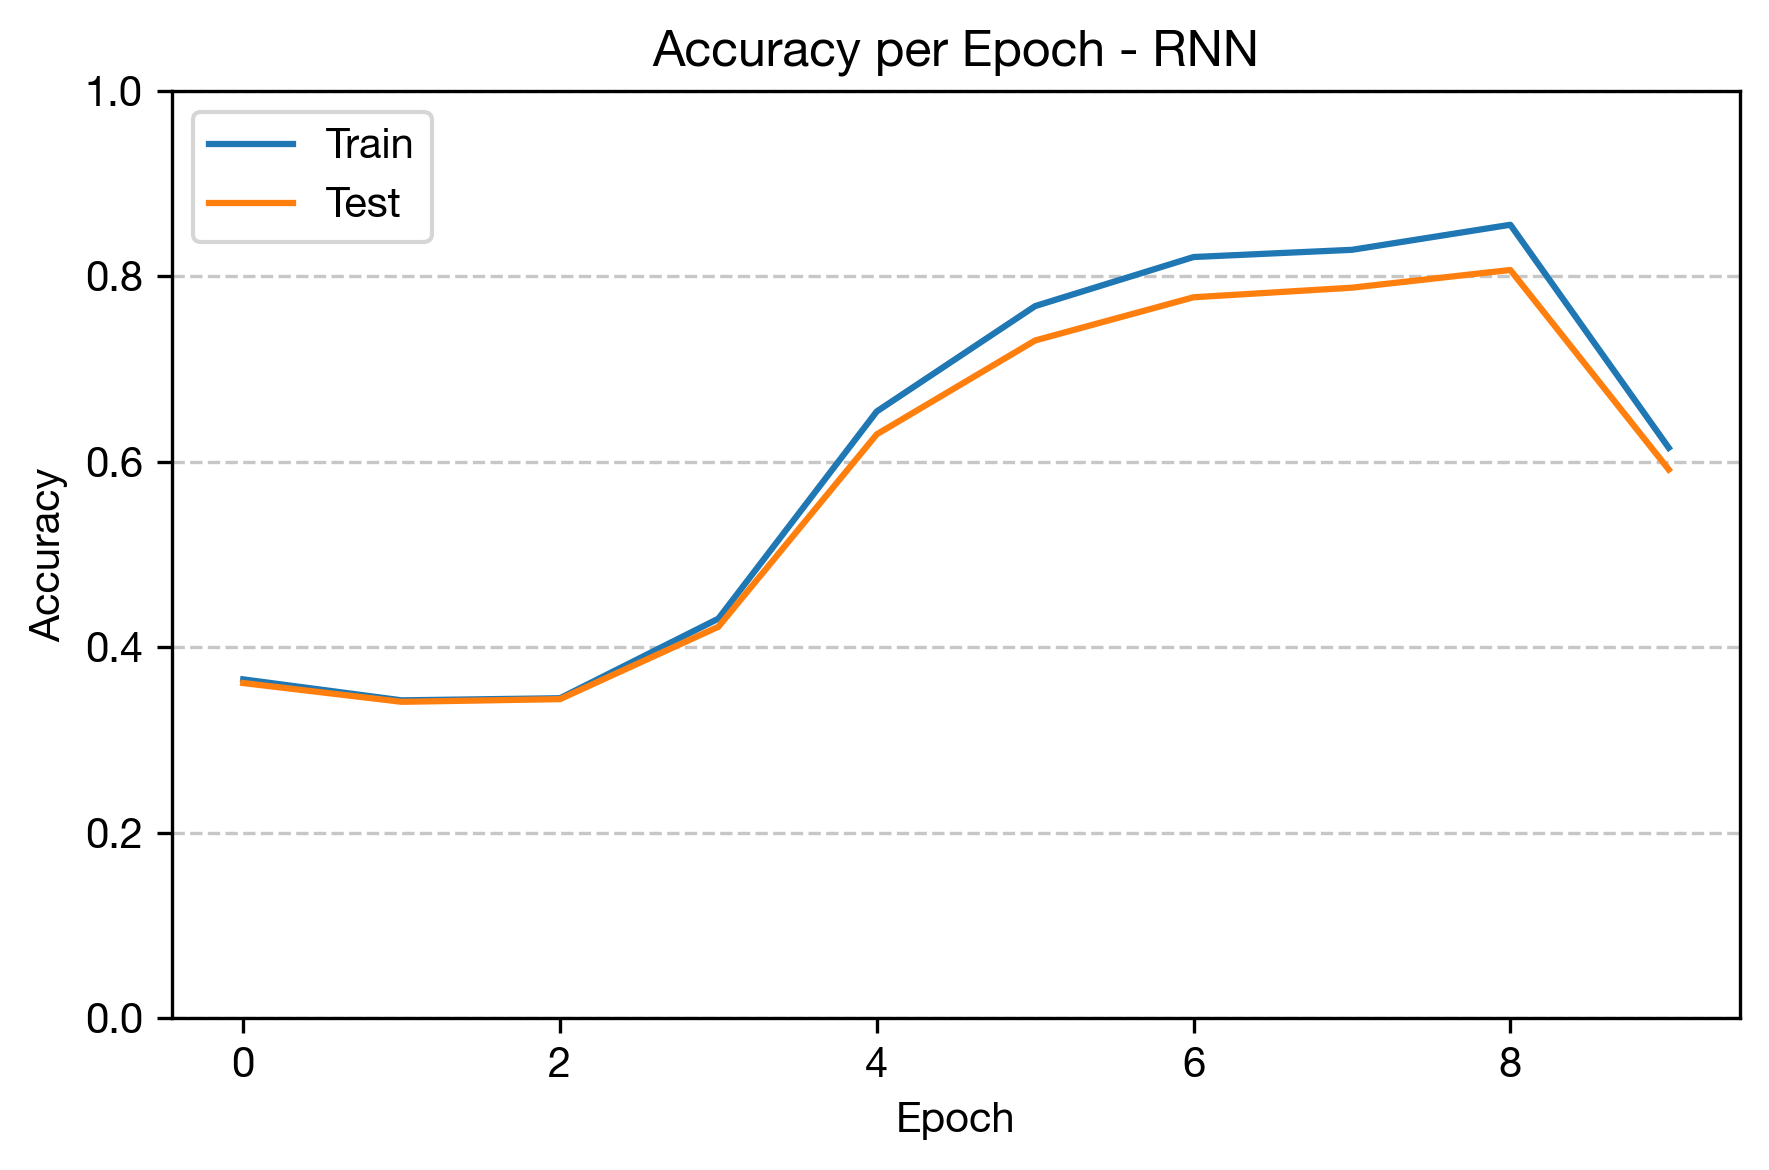

In [26]:
# Plot accuracy
plt.figure(figsize=(6, 4))
plt.plot(rnn_results["train_accuracies"], label="Train")
plt.plot(rnn_results["test_accuracies"], label="Test")
plt.title("Accuracy per Epoch - RNN")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True, linestyle="--", alpha=0.7, axis="y")
plt.legend()
plt.tight_layout()
plt.show()

In [27]:
rnn_results

{'model': RNNClassifier(
   (embedding): Embedding(34128, 100, padding_idx=0)
   (rnn): RNN(100, 128, batch_first=True)
   (fc): Linear(in_features=128, out_features=3, bias=True)
   (activation): LogSoftmax(dim=1)
 ),
 'model_path': 'models/best_rnn.pt',
 'train_accuracies': [0.36540827127177716,
  0.3428086469786114,
  0.345068609407928,
  0.4309090388961466,
  0.6544069267371673,
  0.7680344048288817,
  0.8209385042290858,
  0.828710104988128,
  0.8557342970753988,
  0.6152151732161077],
 'test_accuracies': [0.36144095796872183,
  0.34119625943651255,
  0.3440998017581449,
  0.42215502913554537,
  0.6297482929173592,
  0.7309517611486013,
  0.7775285848735457,
  0.7878611906525962,
  0.8069644966859568,
  0.5917419251486814],
 'confusion_matrix': array([[13948,  2336,   362],
        [ 1332, 11848,  3467],
        [  181,  1962, 14503]]),
 'classification_report': {'0.0': {'precision': 0.9021408705775823,
   'recall': 0.8379190195842845,
   'f1-score': 0.8688448001993335,
   'suppor

In [28]:
save_classification_report(
    rnn_results["labels"],
    rnn_results["preds"],
    "rnn_classification_report.png",
)

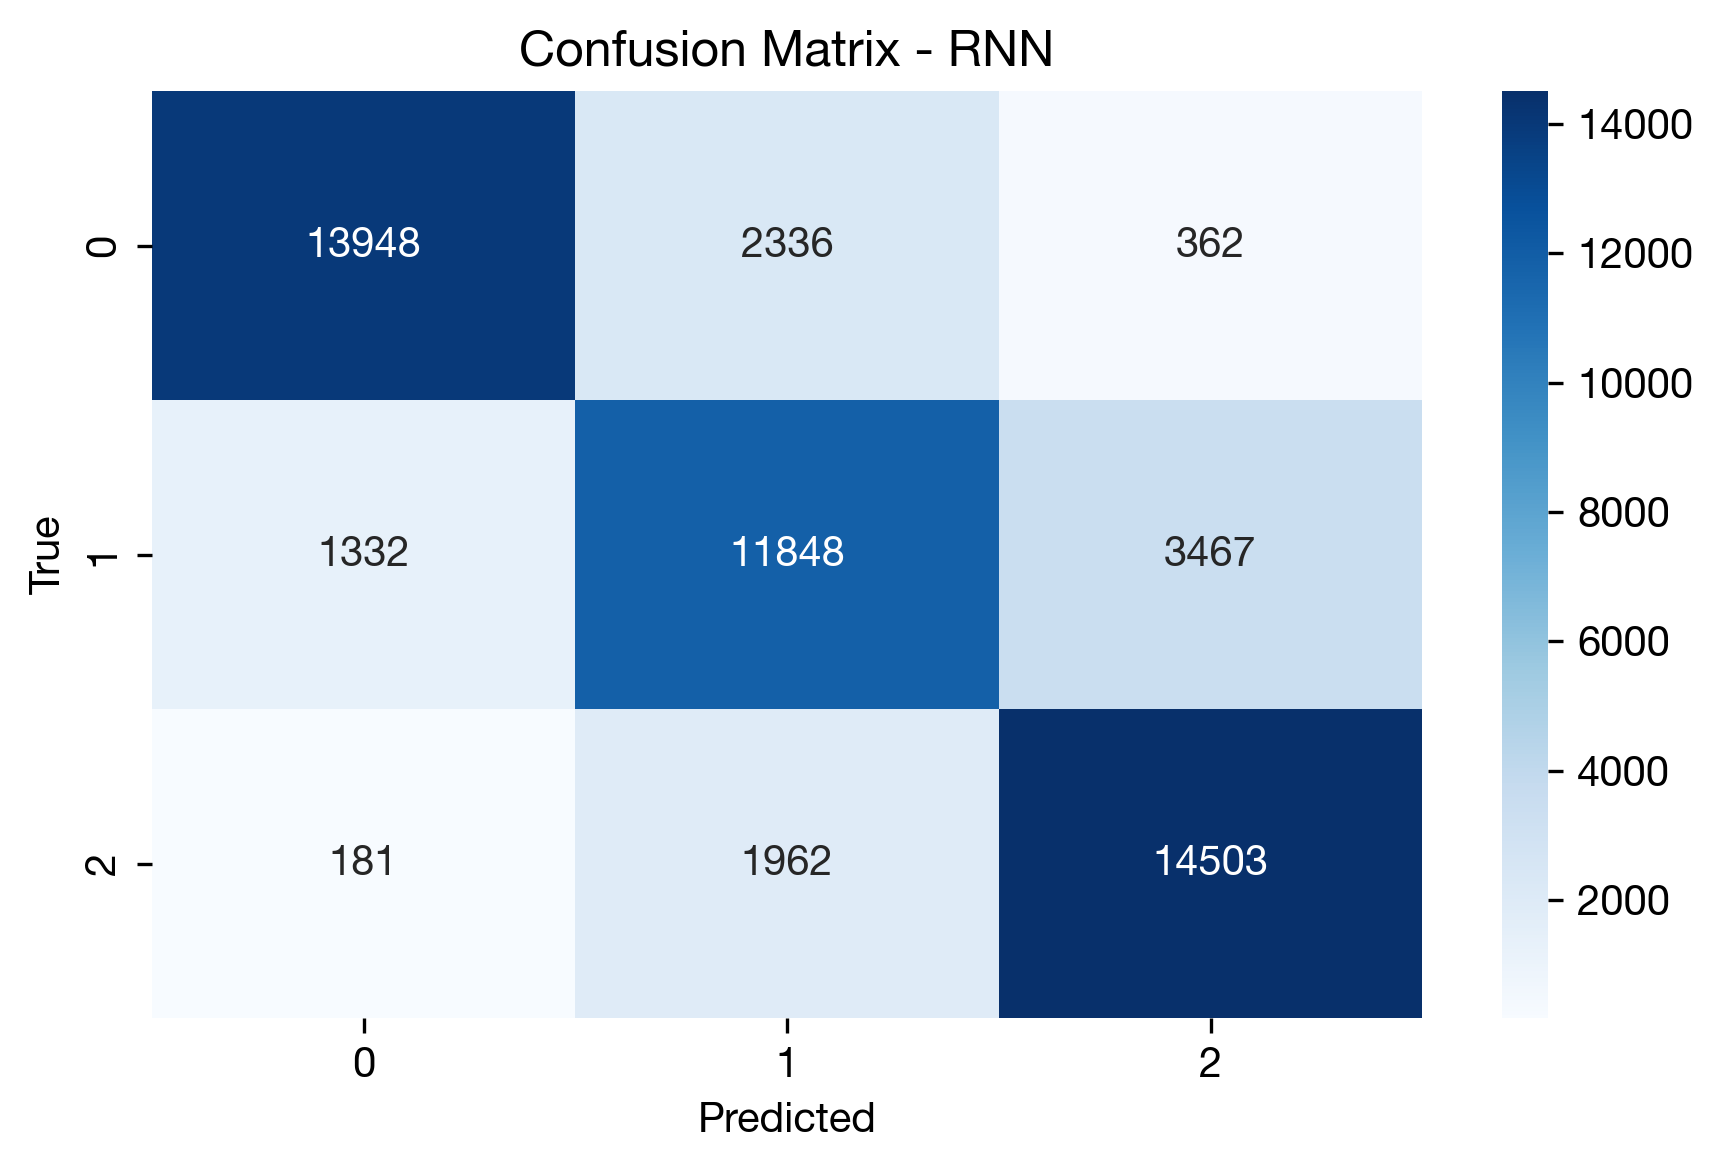

In [29]:
# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(rnn_results["confusion_matrix"], annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - RNN")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

In [30]:
# Classification Report
pprint(rnn_results["classification_report"])

{'0.0': {'f1-score': 0.8688448001993335,
         'precision': 0.9021408705775823,
         'recall': 0.8379190195842845,
         'support': 16646.0},
 '1.0': {'f1-score': 0.7225932363614186,
         'precision': 0.7338040381518642,
         'recall': 0.7117198293986905,
         'support': 16647.0},
 '2.0': {'f1-score': 0.8292641088684316,
         'precision': 0.7911302640192014,
         'recall': 0.8712603628499339,
         'support': 16646.0},
 'accuracy': 0.8069644966859568,
 'macro avg': {'f1-score': 0.8069007151430613,
               'precision': 0.8090250575828827,
               'recall': 0.806966403944303,
               'support': 49939.0},
 'weighted avg': {'f1-score': 0.8068990269338704,
                  'precision': 0.8090235513248593,
                  'recall': 0.8069644966859568,
                  'support': 49939.0}}


In [31]:
def make_json_serializable(obj):
    if isinstance(obj, dict):
        return {k: make_json_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, (list, tuple)):
        return [make_json_serializable(v) for v in obj]
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.float32, np.float64, np.int32, np.int64)):
        return obj.item()
    else:
        return obj

In [32]:
del rnn_results["model"]
del rnn_results["preds"]
del rnn_results["probs"]
rnn_results = make_json_serializable(rnn_results)

with open("results/rnn_results.json", "w") as f:
    json.dump(rnn_results, f, indent=2)

In [33]:
lstm_results = train_and_save_best(LSTMClassifier, "LSTM", bidirectional=True)

🧠 Training LSTM...
Epoch  1: Loss = 0.6360, Train Acc = 0.8601, Test Acc = 0.8306
Epoch  2: Loss = 0.3533, Train Acc = 0.9225, Test Acc = 0.8767
Epoch  3: Loss = 0.2308, Train Acc = 0.9513, Test Acc = 0.8892
Epoch  4: Loss = 0.1556, Train Acc = 0.9689, Test Acc = 0.8986
Epoch  5: Loss = 0.1073, Train Acc = 0.9794, Test Acc = 0.9033
Epoch  6: Loss = 0.0779, Train Acc = 0.9838, Test Acc = 0.9039
Epoch  7: Loss = 0.0584, Train Acc = 0.9868, Test Acc = 0.9030
Epoch  8: Loss = 0.0462, Train Acc = 0.9922, Test Acc = 0.9070
Epoch  9: Loss = 0.0399, Train Acc = 0.9936, Test Acc = 0.9125
Epoch 10: Loss = 0.0335, Train Acc = 0.9946, Test Acc = 0.9115
✅ Saved LSTM with Accuracy = 0.9125 → models/best_lstm.pt


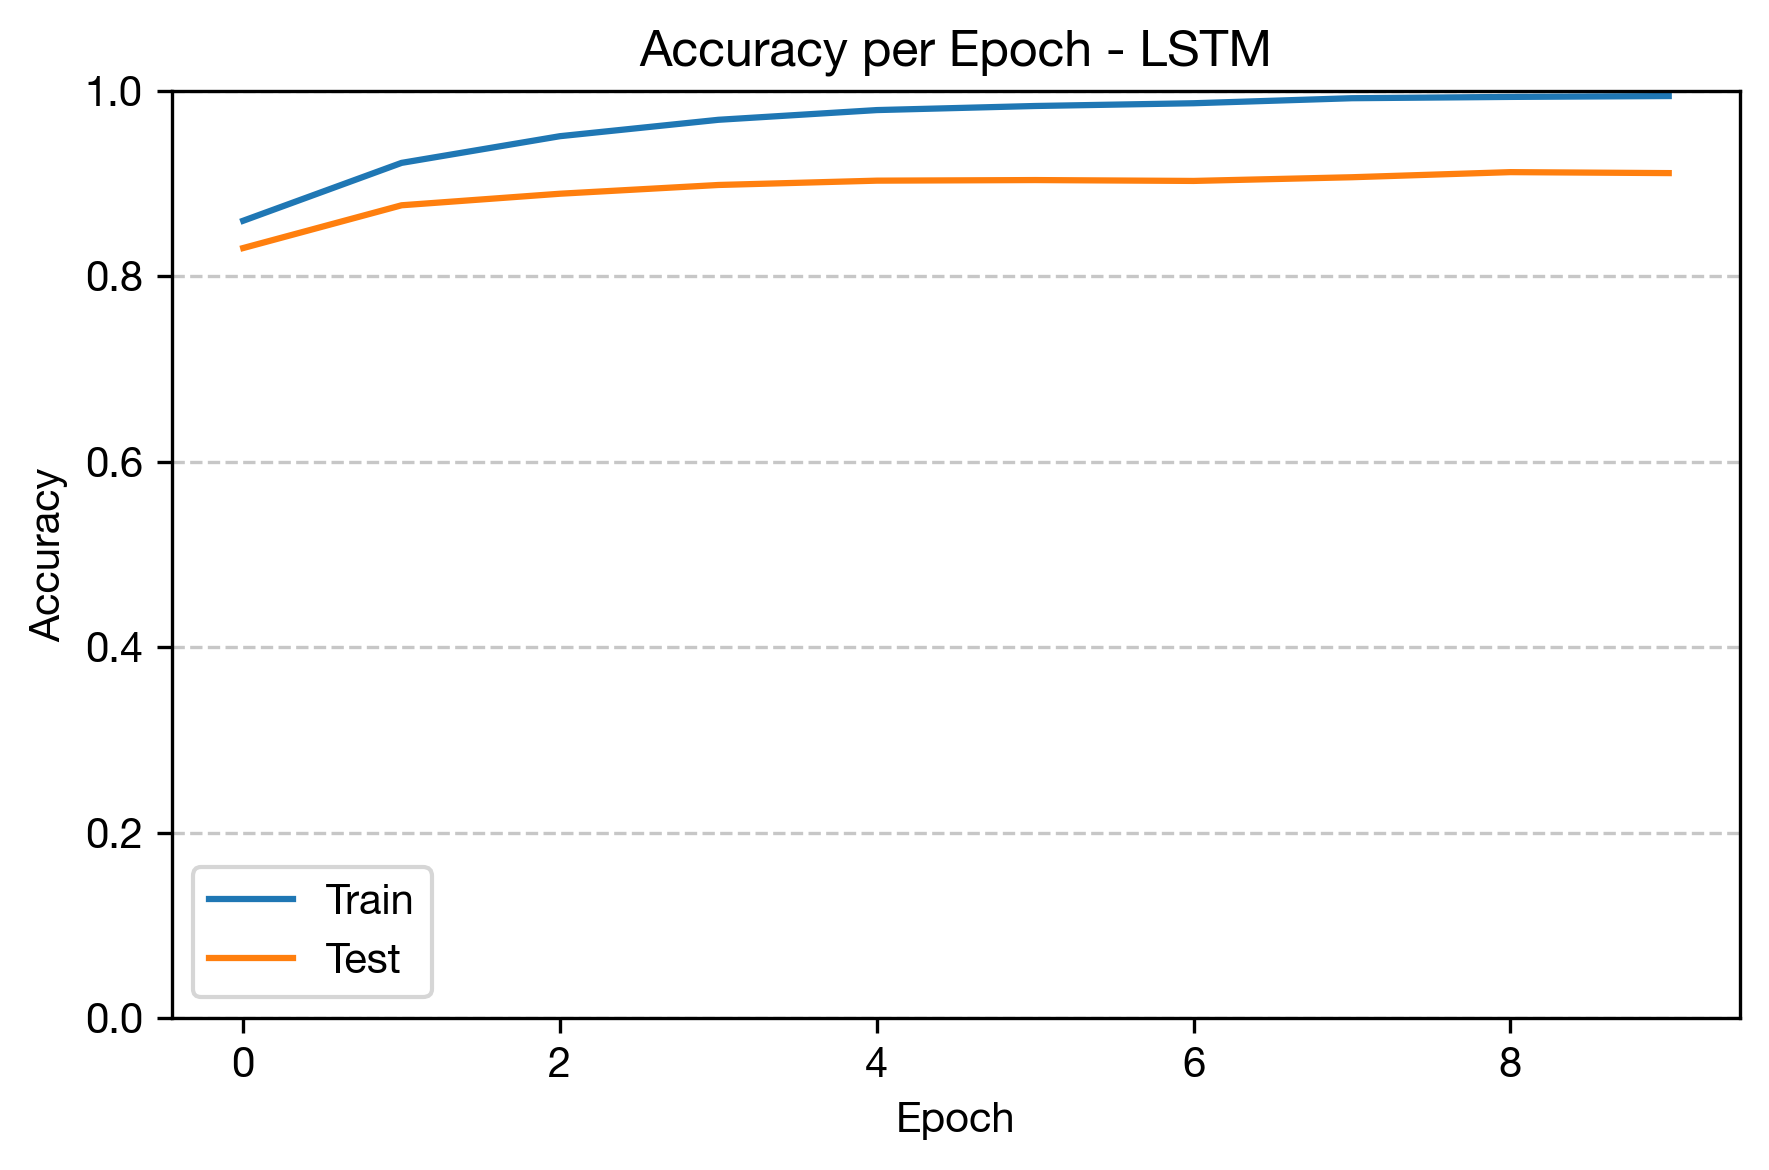

In [34]:
# Plot accuracy
plt.figure(figsize=(6, 4))
plt.plot(lstm_results["train_accuracies"], label="Train")
plt.plot(lstm_results["test_accuracies"], label="Test")
plt.title("Accuracy per Epoch - LSTM")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True, linestyle="--", alpha=0.7, axis="y")
plt.legend()
plt.tight_layout()
plt.show()

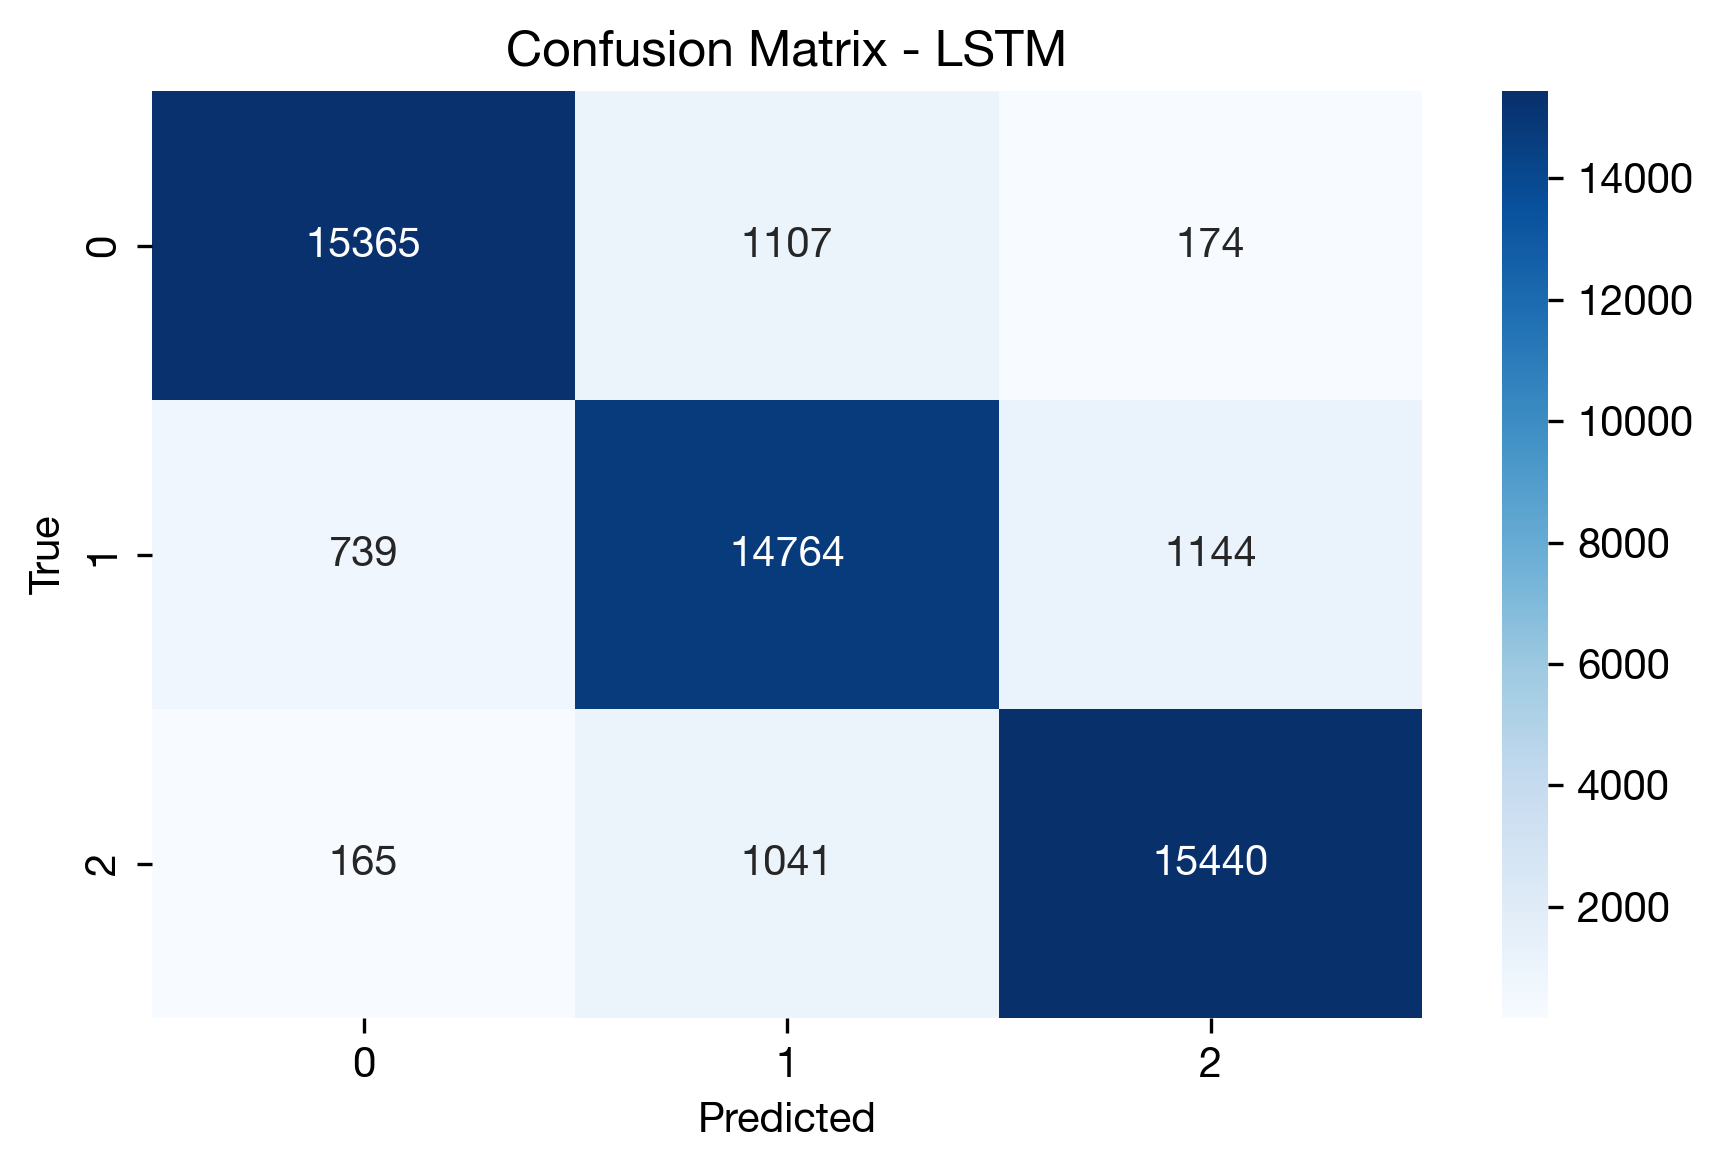

In [35]:
# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(lstm_results["confusion_matrix"], annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - LSTM")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

In [36]:
# Classification Report
pprint(lstm_results["classification_report"])

{'0.0': {'f1-score': 0.9336168919945314,
         'precision': 0.9444342000122933,
         'recall': 0.9230445752733389,
         'support': 16646.0},
 '1.0': {'f1-score': 0.8798831907982956,
         'precision': 0.8729895931882686,
         'recall': 0.886886526100799,
         'support': 16647.0},
 '2.0': {'f1-score': 0.9244401868039755,
         'precision': 0.9213509965389665,
         'recall': 0.9275501622011294,
         'support': 16646.0},
 'accuracy': 0.9124932417549411,
 'macro avg': {'f1-score': 0.9126467565322676,
               'precision': 0.9129249299131761,
               'recall': 0.9124937545250891,
               'support': 49939.0},
 'weighted avg': {'f1-score': 0.9126461004605454,
                  'precision': 0.9129241302308292,
                  'recall': 0.9124932417549411,
                  'support': 49939.0}}


In [37]:
save_classification_report(
    lstm_results["labels"],
    lstm_results["preds"],
    "lstm_classification_report.png",
)

In [38]:
del lstm_results["model"]
del lstm_results["preds"]
del lstm_results["probs"]
lstm_results = make_json_serializable(lstm_results)

with open("results/lstm_results.json", "w") as f:
    json.dump(lstm_results, f, indent=2)